In [1]:
import pandas as pd, numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
import keras._tf_keras.keras.backend as K

import keras._tf_keras.keras.applications.efficientnet as efn

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import re, math
import time

In [2]:
# to remove some warnings

# TF2 way to reduce logging
# this remove also INFO, verify if needed
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [94]:
DEVICE = "GPU" # or "TPU"

# TFRecords file for training (not Kaggle location !)
BASE_DIR = "E:/GAMES/ML/23-2-2025 ML/train"
TFREC_DIR = os.path.join(BASE_DIR, "")

# number of folds for CV
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD 
# CHOOSE 128, 192, 256, 384, 512, 768 

IMG_SIZES = 512

IMAGE_SIZE = [IMG_SIZES, IMG_SIZES]


# tune it, dependes on Image, size, TPU or GPU
BATCH_SIZE = 12

EPOCHS = 25

# WHICH EFFICIENTNET TO USE (B?, B0 from B7)
EFF_NETS = 4

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = 1/FOLDS

NUM_CLASSES = 5

In [95]:
n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", n_gpu)
    
if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

Num GPUs Available:  0
Standard strategy for GPU...
REPLICAS: 1


In [ ]:
# adding some data augmentation
import keras._tf_keras.keras

data_augmentation = keras._tf_keras.keras.Sequential([
  keras._tf_keras.keras.layers.RandomFlip('horizontal'),
  keras._tf_keras.keras.layers.RandomRotation(0.4),
])

In [97]:
# not using metadata (only image, for now)
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        'patient_id' : tf.io.FixedLenFeature([], tf.int64), 
        'side' : tf.io.FixedLenFeature([], tf.int64),
        'label' : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
    patient_id = example['patient_id']
    side = example['side']
    label = example['label']
    
    return image, label

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

# count # of images in files.. (embedded in file name)
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [98]:
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, labels) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [99]:
# here we define the DNN Model

EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

# as default it used B0

def build_model(dim = 256, ef = 0):
    inp = keras._tf_keras.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # introdotta la data augmentation come parte del modello
    x = data_augmentation(inp)
    
    base = EFNS[ef](input_shape=(*IMAGE_SIZE, 3), weights='imagenet', include_top = False)
    
    x = base(x)
    x = keras._tf_keras.keras.layers.GlobalAveragePooling2D()(x)
    x = keras._tf_keras.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = keras._tf_keras.keras.Model(inputs = inp,outputs = x)
    
    opt = keras._tf_keras.keras.optimizers.Adam(learning_rate = 0.001)
    loss = keras._tf_keras.keras.losses.BinaryCrossentropy(label_smoothing=0) 
    
    model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [100]:
model_test = build_model(ef=4)

model_test.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 16, 16, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         8,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,682,788 (67.45 MB)

 Trainable params: 17,557,581 (66.98 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [ ]:
# define sce la variazione temporale del learning rate

def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.000020 * REPLICAS * batch_size/16
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 2
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = keras._tf_keras.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
    
    return lr_callback

In [ ]:
SHOW_FILES = True
VERBOSE = 1
PLOT = 1

skf = KFold(n_splits = FOLDS, shuffle = True, random_state=42)

# for others investigations
# we store all the history
histories = []

# these will be split in folds
num_total_train_files = len(tf.io.gfile.glob('./train/*.jpeg'))
print('Total number of training images: ', num_total_train_files)

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(num_total_train_files))):
    
    tStart = time.time()
    
    # display fold info
    print('#'*60) 
    print('#### FOLD', fold+1)
    
    print('#### Image Size %i, EfficientNet B%i, batch_size %i'%
          (IMG_SIZES, EFF_NETS, BATCH_SIZE*REPLICAS))
    print('#### Epochs: %i' %(EPOCHS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([ './train/*.jpeg'%x for x in idxT])
    
    np.random.shuffle(files_train) 
    print('#'*60)
    
    files_valid = tf.io.gfile.glob(['./train/*.jpeg'%x for x in idxV])
    
    if SHOW_FILES:
        print('Number of training images', count_data_items(files_train))
        print('Number of validation images', count_data_items(files_valid))
        
    # BUILD MODEL
    if DEVICE=='TPU':
        # to avoid OOM
        tf.tpu.experimental.initialize_tpu_system(gpu)
            
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES, ef=EFF_NETS)
        
    sv = keras.callbacks.ModelCheckpoint(
    filepath='fold-%i.weights.h5' % fold,  # Change ".h5" to ".weights.h5"
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,  # Saving only weights
    mode='min',
    save_freq='epoch'
)
    
    csv_logger = keras._tf_keras.keras.callbacks.CSVLogger('training_retina-%i.log'%fold)
    
    # TRAIN
    history = model.fit(
        get_training_dataset(files_train), 
        epochs=EPOCHS, 
        callbacks = [sv, get_lr_callback(BATCH_SIZE), csv_logger], 
        steps_per_epoch = count_data_items(files_train)/BATCH_SIZE//REPLICAS,
        validation_data = get_training_dataset(files_valid), 
        validation_steps = count_data_items(files_valid)/BATCH_SIZE//REPLICAS,
        verbose=VERBOSE)
    
    # save all histories
    histories.append(history)
    
    tElapsed = round(time.time() - tStart, 1)
    
    print(' ')
    print('Time (sec) elapsed for fold: ', tElapsed)
    print('...')
    print('...')

Total number of training images:  35126
############################################################
#### FOLD 1
#### Image Size 512, EfficientNet B4, batch_size 12
#### Epochs: 25


In [ ]:
def plot_loss(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['loss'], label='Training loss')
    plt.plot(hist.history['val_loss'], label='Validation loss')
    plt.title('Loss fold n. ' + str(fold + 1) )
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show()

In [ ]:
for fold in range(FOLDS):
    plot_loss(histories[fold])

In [ ]:
def plot_acc(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['accuracy'], label='Training accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy fold n. ' + str(fold + 1) )
    plt.legend(loc='lower right')
    plt.ylabel('Acc')
    plt.xlabel('epoch')
    plt.grid()
    plt.show()

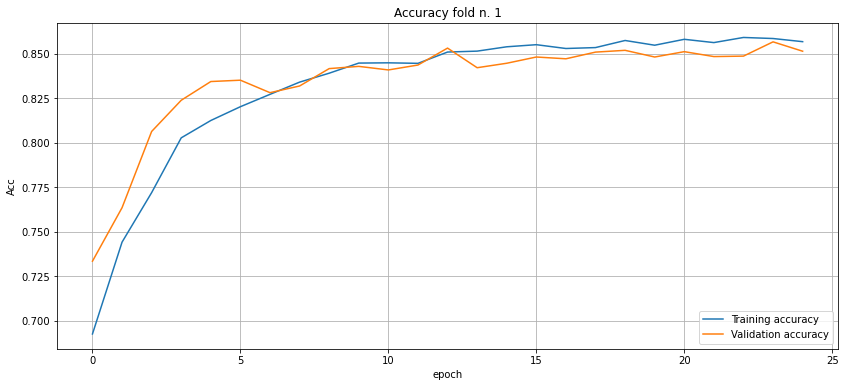

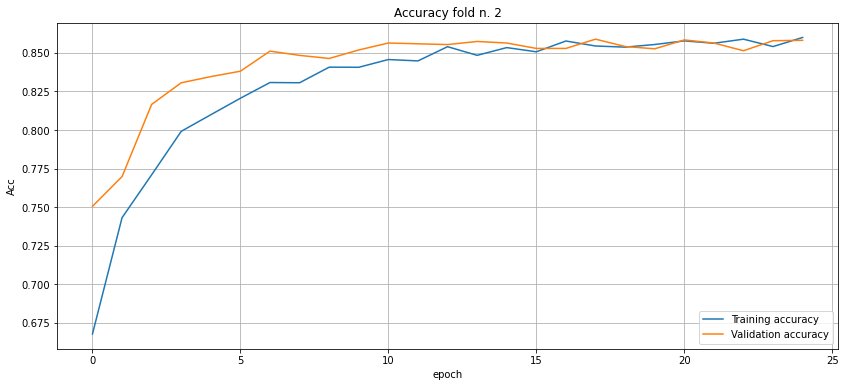

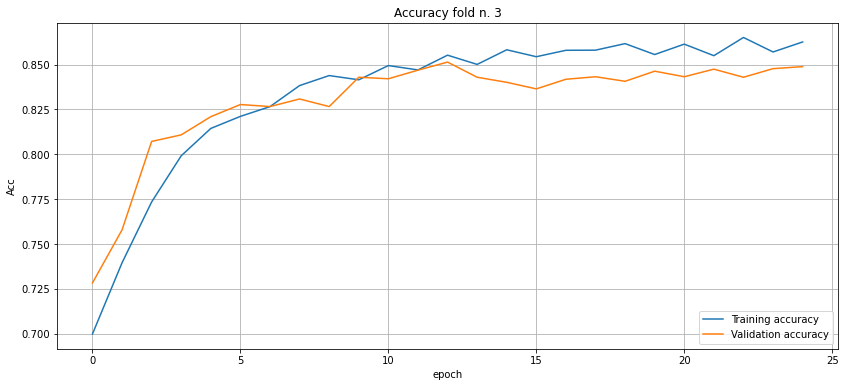

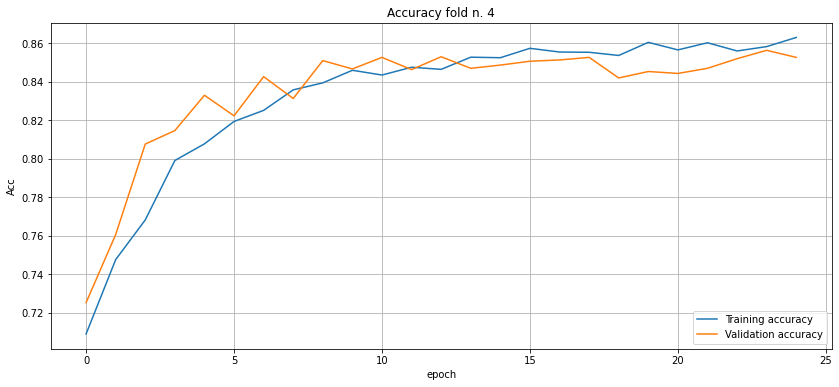

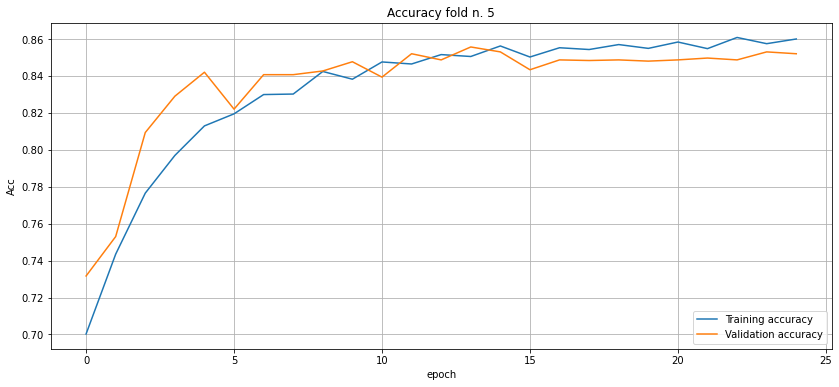

In [ ]:
for fold in range(FOLDS):
    plot_acc(histories[fold])

In [ ]:
files_test = tf.io.gfile.glob(TFREC_DIR + '/train*.tfrec')

num_total_test_files = len(tf.io.gfile.glob(TFREC_DIR + '/train*.tfrec'))

wi = [1/FOLDS]*FOLDS

avg_acc = 0

for fold in range(FOLDS):
    model.load_weights('fold-%i.h5'%fold)
    
    test_loss, test_acc = model.evaluate(get_training_dataset(files_test), verbose = 0, batch_size = 4*BATCH_SIZE,
                                        steps = num_total_test_files/4*BATCH_SIZE//REPLICAS)

    print('Train accuracy fold n.', fold+1, ': ', round(test_acc, 4))

    avg_acc += test_acc * wi[fold]

print('Average accuracy: ', round(avg_acc,4))